## Work
1. 請比較使用不同層數以及不同 Dropout rate 對訓練的效果
2. 將 optimizer 改成使用 Adam 並加上適當的 dropout rate 檢視結果

In [1]:
import os
import keras
import itertools
from keras.datasets import cifar10
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from keras.optimizers import adam
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)
input_shape = x_train.shape[1:]

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
def build_mlp(input_shape, hidden_neuron_units, dropout_rate, output_shape):
    input_layer = Input(shape=input_shape)
    for ind, num in enumerate(hidden_neuron_units):
        if ind == 0:
            x = Dense(units=num, activation='relu')(input_layer)
        else:
            x = Dense(units=num, activation='relu')(x)
            
    x = Dropout(dropout_rate)(x)
    output_layer = Dense(output_shape, activation='softmax')(x)
    
    model = Model(inputs=[input_layer], outputs=[output_layer])
    
    return model

model = build_mlp(input_shape, hidden_neuron_units=[256, 128], dropout_rate=0.3, output_shape=10)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               786688    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290      
Total params: 820,874
Trainable params: 820,874
Non-trainable params: 0
_________________________________________________________________


In [10]:
## 超參數設定
EPOCHS = 10
LEARNING_RATE = 1e-3
BATCH_SIZE = 256
DROPOUT_RATE = [.3, .4, .5]
HIDDEN_NEURON_UNITS = [256, 128]
OUTPUT_SHAPE = 10

In [11]:
results = {}
for rate in DROPOUT_RATE:
    keras.backend.clear_session()
    model = build_mlp(input_shape=input_shape,
                      hidden_neuron_units=HIDDEN_NEURON_UNITS,
                      dropout_rate=rate, output_shape=OUTPUT_SHAPE)
    
    model.compile(optimizer=adam(lr=LEARNING_RATE),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    model.fit(x_train, y_train, epochs=EPOCHS,
              batch_size=BATCH_SIZE,
              validation_data=(x_test, y_test),shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    experiment = 'DropRate:{}'.format(rate)
    results[experiment] = {
        'train_loss': train_loss,
        'valid_loss': valid_loss,
        'train_acc': train_acc,
        'valid_acc': valid_acc
    }

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 3s 64us/step - loss: 2.0246 - acc: 0.2632 - val_loss: 1.8472 - val_acc: 0.3405
Epoch 2/10
50000/50000 [==============================] - 3s 59us/step - loss: 1.8051 - acc: 0.3521 - val_loss: 1.7114 - val_acc: 0.3836
Epoch 3/10
50000/50000 [==============================] - 3s 59us/step - loss: 1.7250 - acc: 0.3872 - val_loss: 1.6549 - val_acc: 0.4058
Epoch 4/10
50000/50000 [==============================] - 3s 59us/step - loss: 1.6666 - acc: 0.4044 - val_loss: 1.6355 - val_acc: 0.4233
Epoch 5/10
50000/50000 [==============================] - 3s 59us/step - loss: 1.6326 - acc: 0.4198 - val_loss: 1.5548 - val_acc: 0.4488
Epoch 6/10
50000/50000 [==============================] - 3s 62us/step - loss: 1.5904 - acc: 0.4376 - val_loss: 1.5516 - val_acc: 0.4533
Epoch 7/10
50000/50000 [==============================] - 3s 61us/step - loss: 1.5678 - acc: 0.4427 - val_loss: 1.5180 - val_acc

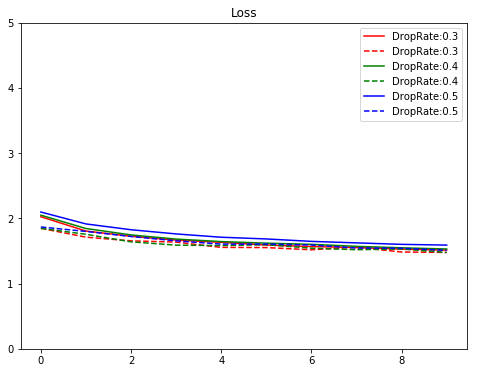

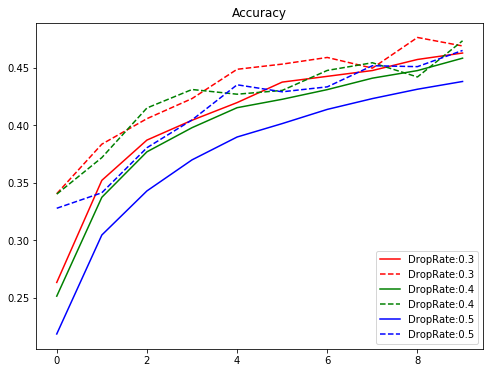

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train_loss'])),results[cond]['train_loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid_loss'])),results[cond]['valid_loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train_acc'])),results[cond]['train_acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid_acc'])),results[cond]['valid_acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()